#### Step 1: Data Preparation and Initial Analysis

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import torch
import torch.nn as nn
from torch.optim import Adam
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

In [41]:
# Load and prepare data
data = pd.read_csv('Fuel_Consumption_2000-2022.csv')
data = data[['YEAR', 'COMB (L/100 km)']]
data['YEAR'] = pd.to_datetime(data['YEAR'], format='%Y')
data.set_index('YEAR', inplace=True)

In [43]:
# Aggregate yearly
annual_data = data.resample('YE').mean()

In [44]:
# Normalize for LSTM and XGBoost
scaler = MinMaxScaler()
annual_data['Scaled_Comb'] = scaler.fit_transform(annual_data[['COMB (L/100 km)']])

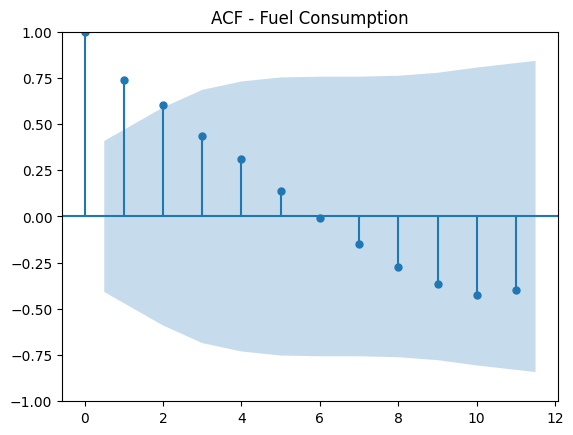

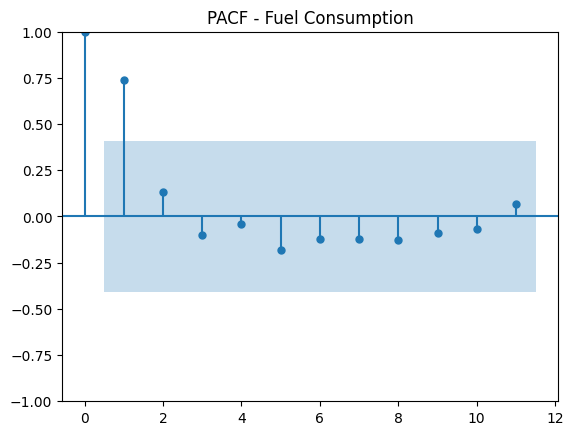

In [45]:
# Plot ACF and PACF
plot_acf(annual_data['COMB (L/100 km)'])
plt.title('ACF - Fuel Consumption')
plt.show()

plot_pacf(annual_data['COMB (L/100 km)'])
plt.title('PACF - Fuel Consumption')
plt.show()

In [46]:
# Train-test split
train_size = int(len(annual_data) * 0.67)
train, test = annual_data.iloc[:train_size], annual_data.iloc[train_size:]

In [47]:
# ARIMA Model
model_arima = ARIMA(train['COMB (L/100 km)'], order=(1,1,1))
results_arima = model_arima.fit()
forecast_arima = results_arima.get_forecast(steps=len(test))
forecast_ci = forecast_arima.conf_int()

In [54]:
# LSTM Preparation
train_tensor = torch.tensor(train[['Scaled_Comb']].values, dtype=torch.float32)
train_tensor = train_tensor.view(-1, 1, 1)  # [batch, seq_len=1, input_size=1]

test_tensor = torch.tensor(test[['Scaled_Comb']].values, dtype=torch.float32)
test_tensor = test_tensor.view(-1, 1, 1)

# LSTM Model Definition
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=100, batch_first=True)
        self.linear = nn.Linear(100, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.linear(lstm_out[:, -1, :])

# Initialize model, loss, and optimizer
model_lstm = LSTMModel()
loss_fn = nn.MSELoss()
optimizer = Adam(model_lstm.parameters(), lr=0.01)

# Train LSTM
for epoch in range(100):
    model_lstm.train()
    optimizer.zero_grad()

    output = model_lstm(train_tensor)  # shape [batch, 1, 1] → [batch, 1]
    target = train_tensor[:, -1, :]    # get the last time step for comparison

    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss.item():.6f}")


Epoch 10 | Loss: 0.076206
Epoch 20 | Loss: 0.051631
Epoch 30 | Loss: 0.032622
Epoch 40 | Loss: 0.021356
Epoch 50 | Loss: 0.010185
Epoch 60 | Loss: 0.001528
Epoch 70 | Loss: 0.000613
Epoch 80 | Loss: 0.000449
Epoch 90 | Loss: 0.000065
Epoch 100 | Loss: 0.000094


In [55]:
# LSTM Predictions
model_lstm.eval()
with torch.no_grad():
    lstm_output = model_lstm(test_tensor)
    lstm_predictions = scaler.inverse_transform(lstm_output.numpy())

In [56]:
# XGBoost with Lagged Features
annual_data['Lag1'] = annual_data['Scaled_Comb'].shift(1)
xgb_data = annual_data.dropna()
X = xgb_data[['Lag1']]
y = xgb_data['Scaled_Comb']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=len(test)/len(xgb_data), shuffle=False)

xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_predictions = scaler.inverse_transform(xgb_pred.reshape(-1, 1))

In [57]:
# True values
true_values_arima = test['COMB (L/100 km)'].values
true_values_lstm = test['COMB (L/100 km)'].values
true_values_xgb = scaler.inverse_transform(y_test.values.reshape(-1, 1))

In [58]:
# Evaluation function
def evaluate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

In [59]:
# Evaluate
arima_metrics = evaluate_metrics(true_values_arima, forecast_arima.predicted_mean.values)
lstm_metrics = evaluate_metrics(true_values_lstm, lstm_predictions)
xgb_metrics = evaluate_metrics(true_values_xgb, xgb_predictions)

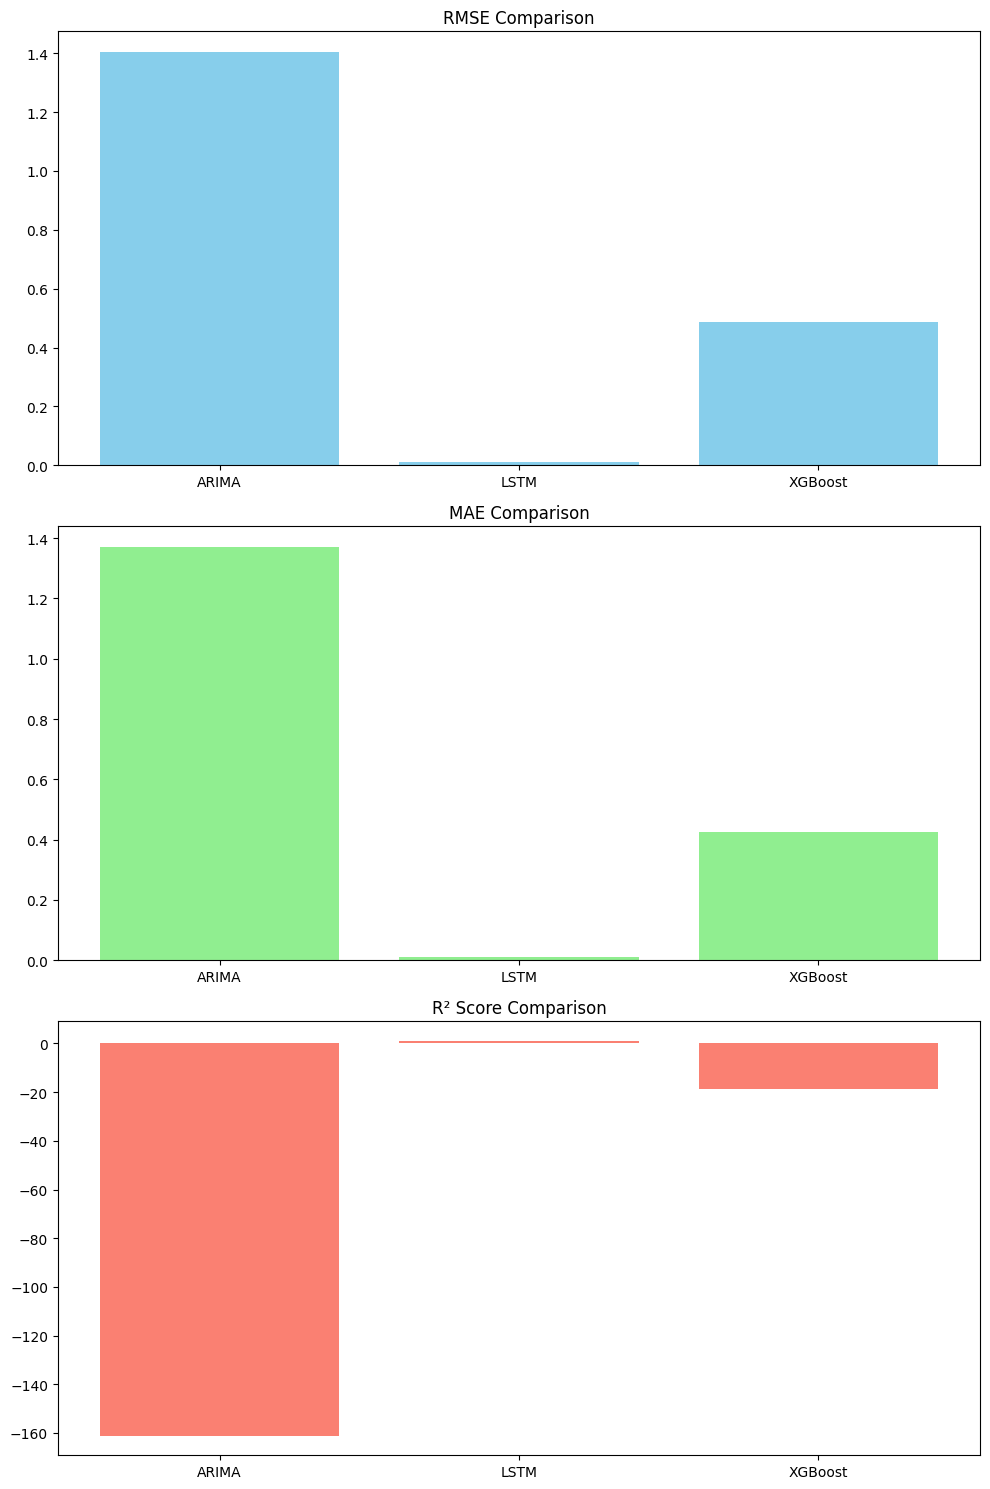

In [60]:
# Plot comparison
labels = ['ARIMA', 'LSTM', 'XGBoost']
rmse = [arima_metrics[0], lstm_metrics[0], xgb_metrics[0]]
mae = [arima_metrics[1], lstm_metrics[1], xgb_metrics[1]]
r2 = [arima_metrics[2], lstm_metrics[2], xgb_metrics[2]]

fig, ax = plt.subplots(3, 1, figsize=(10, 15))
ax[0].bar(labels, rmse, color='skyblue')
ax[0].set_title('RMSE Comparison')
ax[1].bar(labels, mae, color='lightgreen')
ax[1].set_title('MAE Comparison')
ax[2].bar(labels, r2, color='salmon')
ax[2].set_title('R² Score Comparison')
plt.tight_layout()
plt.show()

In [63]:
# Print Evaluation Metrics for All Models
print("Model Evaluation Metrics\n")

print("🔹 ARIMA:")
print(f"   RMSE: {arima_metrics[0]:.4f}")
print(f"   MAE : {arima_metrics[1]:.4f}")
print(f"   R²  : {arima_metrics[2]:.4f}\n")

print("🔹 LSTM:")
print(f"   RMSE: {lstm_metrics[0]:.4f}")
print(f"   MAE : {lstm_metrics[1]:.4f}")
print(f"   R²  : {lstm_metrics[2]:.4f}\n")

print("🔹 XGBoost:")
print(f"   RMSE: {xgb_metrics[0]:.4f}")
print(f"   MAE : {xgb_metrics[1]:.4f}")
print(f"   R²  : {xgb_metrics[2]:.4f}")

Model Evaluation Metrics

🔹 ARIMA:
   RMSE: 1.4041
   MAE : 1.3706
   R²  : -161.0819

🔹 LSTM:
   RMSE: 0.0098
   MAE : 0.0098
   R²  : 0.9920

🔹 XGBoost:
   RMSE: 0.4884
   MAE : 0.4252
   R²  : -18.6124


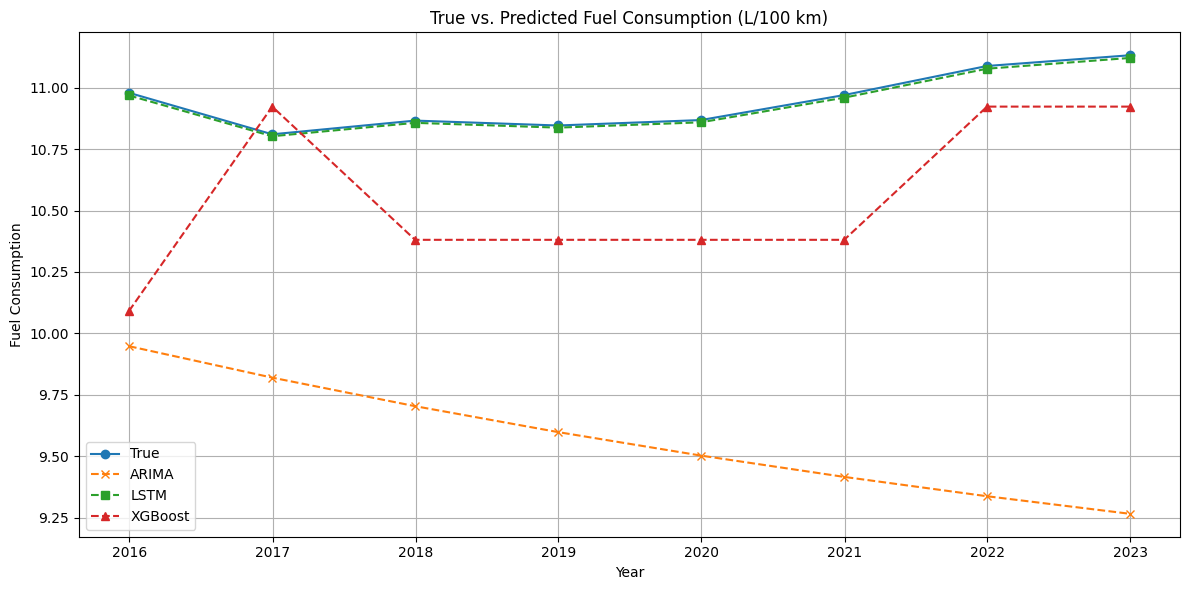

In [64]:
# forecast plot: True vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['COMB (L/100 km)'].values, label='True', marker='o')
plt.plot(test.index, forecast_arima.predicted_mean.values, label='ARIMA', linestyle='--', marker='x')
plt.plot(test.index, lstm_predictions, label='LSTM', linestyle='--', marker='s')
plt.plot(test.index, xgb_predictions, label='XGBoost', linestyle='--', marker='^')
plt.title('True vs. Predicted Fuel Consumption (L/100 km)')
plt.xlabel('Year')
plt.ylabel('Fuel Consumption')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

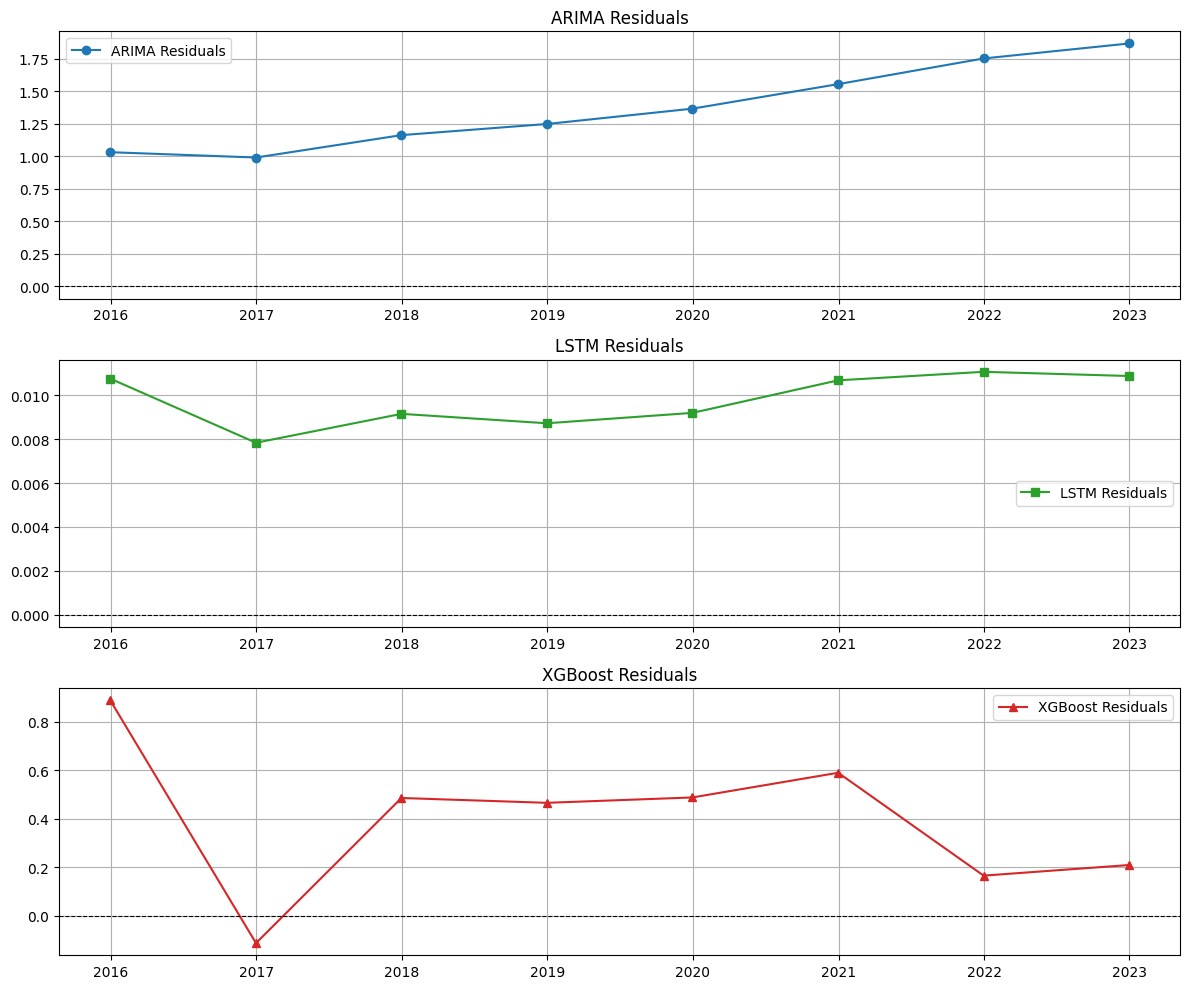

In [68]:
# Residuals: calculate and plot
residuals_arima = test['COMB (L/100 km)'].values - forecast_arima.predicted_mean.values
residuals_lstm = test['COMB (L/100 km)'].values - lstm_predictions.flatten()
residuals_xgb = test['COMB (L/100 km)'].values - xgb_predictions.flatten()

# Residual Plots
fig, ax = plt.subplots(3, 1, figsize=(12, 10))

ax[0].plot(test.index, residuals_arima, label='ARIMA Residuals', color='tab:blue', marker='o')
ax[0].axhline(0, color='black', linestyle='--', linewidth=0.8)
ax[0].set_title('ARIMA Residuals')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(test.index, residuals_lstm, label='LSTM Residuals', color='tab:green', marker='s')
ax[1].axhline(0, color='black', linestyle='--', linewidth=0.8)
ax[1].set_title('LSTM Residuals')
ax[1].legend()
ax[1].grid(True)

ax[2].plot(test.index, residuals_xgb, label='XGBoost Residuals', color='tab:red', marker='^')
ax[2].axhline(0, color='black', linestyle='--', linewidth=0.8)
ax[2].set_title('XGBoost Residuals')
ax[2].legend()
ax[2].grid(True)

plt.tight_layout()
plt.show()